In [0]:
!pip install numpy==1.16.1
!pip install tensorflow-gpu==2.0.0-beta1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, AveragePooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

LR = LeakyReLU(alpha = .3)
LR.__name__ = 'leakyrelu'

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# fix random seed for reproducibility
seed = 2
np.random.seed(seed)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pre-Settings

In [0]:
Test = "test2"
Version = "_univ_" #="univ"
VarName = "GSPC"


if Test == "test1":
  tr_direct = "data_train_to2005"
  ts_direct = "data_test_2005Decto_2007Dec"
elif Test == "test2":
  tr_direct = "data_train_to2007"
  ts_direct = "data_test_2008Jan_to_2010Jan"
else:
  tr_direct = "data_train_to2017May"
  ts_direct = "data_test_2017May_to_2019last"

# Load data

In [0]:
if Version == "_indiv_":
  train_filename = "LW5_IW30/" + tr_direct + "/" + Version[1:] + "train" + Test[-1] + "_" + VarName + "_1B_ReturnTrue_LWS5_IWS30_Trf['RP', 'GASF', 'MTF'].npz"
else:
  train_filename = "LW5_IW30/" + tr_direct + "/" + Version[1:] + "train" + Test[-1] + "_1B_ReturnTrue_LWS5_IWS30_Trf['RP', 'GASF', 'MTF'].npz"
  
test_filename = "LW5_IW30/" + ts_direct + "/" + Test + "_" + VarName + "_1B_ReturnTrue_LWS5_IWS30_Trf['RP', 'GASF', 'MTF'].npz"

### Image window sizes

In [0]:
Image_window_size = np.int(train_filename[train_filename.find('_IWS') + 4 : train_filename.find("_Trf")])
Image_window_size

30

### Transformation types

In [0]:
Image_trf = eval(train_filename[train_filename.find('_Trf')+4:train_filename.find('.npz')])
Image_trf

['RP', 'GASF', 'MTF']

In [0]:
num_color_channels = len(Image_trf)
num_color_channels

3

#### In case file is missing run the data-check-and-prep with preferred settings and use the new file's name (cannot upload too big files to Git)

In [0]:
data_train = np.load('/content/drive/My Drive/Colab Notebooks/CNN/' + train_filename)
data_test = np.load('/content/drive/My Drive/Colab Notebooks/CNN/' + test_filename)

In [0]:
images_train = data_train['images']
images_test = data_test['images']
image_labels_train = data_train['image_labels']
image_labels_test = data_test['image_labels']
train_prices = data_train['price_at_image']
test_prices = data_test['price_at_image']

label_names = data_train['label_names'] # same everywhere

Load all test files into one big concatenated one for validation

In [0]:
Names = ['IXIC', 'AAPL', 'N225', 'SPY']
for names in Names:
  test_filename = "LW5_IW30/" + ts_direct + "/" + Test + "_" + names + "_1B_ReturnTrue_LWS5_IWS30_Trf['RP', 'GASF', 'MTF'].npz"
  data_test = np.load('/content/drive/My Drive/Colab Notebooks/CNN/' + test_filename)
  
  images_test = np.append(images_test, data_test['images'], axis = 0)
  image_labels_test = np.append(image_labels_test, data_test['image_labels'], axis = 0)
  test_prices = np.append(test_prices, data_test['price_at_image'], axis = 0)


# Check data

In [0]:
image_labels_train.shape

(216072, 3)

Get label names array for later visualization

In [0]:
label_names = label_names.item()
label_names

{0: 'Sell', 1: 'Buy', 2: 'Hold'}

In [0]:
label_names_array = np.chararray(3, itemsize = 4).decode("utf-8")

for key, value in label_names.items():
  label_names_array[key] = value
label_names_array

array(['Sell', 'Buy', 'Hold'], dtype='<U4')

## e.g.:

Transformation type: RP


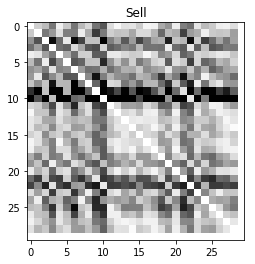

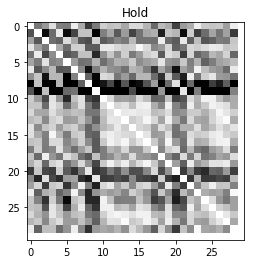

Transformation type: GASF


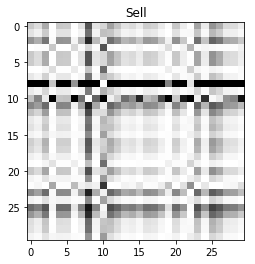

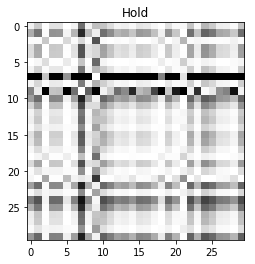

Transformation type: MTF


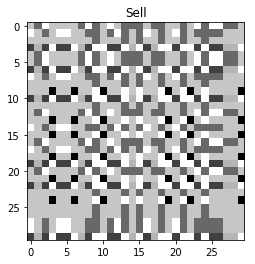

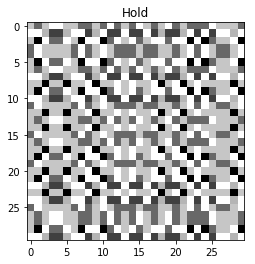

In [0]:
for trfidx, trf in enumerate(Image_trf):
    print('Transformation type: ' + trf)
    for idx, image in enumerate(images_train[:2,:,:, trfidx]):
        plt.imshow(image, cmap = "Greys")
        plt.title(label_names[np.int(np.argwhere(image_labels_train[idx]))])
        plt.show()

In [0]:
print("Train images shape : {}; Train labels shape : {}".format(images_train.shape, image_labels_train.shape))

Train images shape : (216072, 30, 30, 3); Train labels shape : (216072, 3)


In [0]:
print("Test images shape : {}; Test labels shape : {}".format(images_test.shape, image_labels_test.shape))

Test images shape : (2605, 30, 30, 3); Test labels shape : (2605, 3)


# Baseline predictions
Choosing the biggest class to be the class of all

In [0]:
basepred = np.zeros(image_labels_test.shape)
basepred[:, np.argmax(np.sum(image_labels_test, 0))] = 1.0

base_acc = sum(np.equal(np.argmax(basepred, 1), np.argmax(image_labels_test, 1)))/np.sum(image_labels_test)
base_f1 = f1_score(y_true = image_labels_test, y_pred = basepred, average = 'macro')
# warning F1 due to only label 2 being predicted in baseline

print("Accuracy: {:.5f}".format(base_acc))
print("Categorical Accuracy: {:.5f}".format(accuracy_score(np.argmax(basepred, 1), np.argmax(image_labels_test, 1))))

print("F1 score: {:.5f}".format(base_f1))

print(classification_report(np.argmax(basepred, 1), np.argmax(image_labels_test, 1)))

Accuracy: 0.71209
Categorical Accuracy: 0.71209
F1 score: 0.27728
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.71      0.83      2605

    accuracy                           0.71      2605
   macro avg       0.33      0.24      0.28      2605
weighted avg       1.00      0.71      0.83      2605



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# The Deep CNN

### Custom Keras Eval metrics: F1 Score
https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2

In [0]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import fbeta_score

# Some default constants

START = 0.5
END = 0.95
STEP = 0.05
N_STEPS = int((END - START) / STEP) + 2
DEFAULT_THRESHOLDS = np.linspace(START, END, N_STEPS)
DEFAULT_BETA = 1
DEFAULT_LOGS = {}
FBETA_METRIC_NAME = "val_fbeta"

class FBetaMetricCallback(Callback):

    def __init__(self, beta=DEFAULT_BETA, thresholds=DEFAULT_THRESHOLDS):
        self.beta = beta
        self.thresholds = thresholds
        # Will be initialized when the training starts
        self.val_fbeta = None

    def on_train_begin(self, logs=DEFAULT_LOGS):
        """ This is where the validation Fbeta
        validation scores will be saved during training: one value per
        epoch.
        """
        self.val_fbeta = []

    def _score_per_threshold(self, predictions, targets, threshold):
        """ Compute the Fbeta score per threshold.
        """
        # Notice that here I am using the sklearn fbeta_score function.
        # You can read more about it here:
        # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
        thresholded_predictions = (predictions > threshold).astype(int)
        return fbeta_score(targets, thresholded_predictions, beta=self.beta)

    def on_epoch_end(self, epoch, logs=DEFAULT_LOGS):
        val_predictions = self.model.predict(self.validation_data[0])
        val_targets = self.validation_data[1]
        _val_fbeta = np.mean([self._score_per_threshold(val_predictions,
                                                        val_targets, threshold)
                              for threshold in self.thresholds])
        self.val_fbeta.append(_val_fbeta)
        print("Current F{} metric is: {}".format(str(self.beta), str(_val_fbeta)))
        return

    def on_train_end(self, logs=DEFAULT_LOGS):
        """ Assign the validation Fbeta computed metric to the History object.
        """
        self.model.history.history[FBETA_METRIC_NAME] = self.val_fbeta
        
f1_score = FBetaMetricCallback(beta=1)

### Custom Time Logging

In [0]:
import tensorflow.keras.callbacks as keras_cb

class TimeHistory(keras_cb.Callback):
  def on_train_begin(self, logs={}):
    self.times = []

  def on_epoch_begin(self, epoch, logs={}):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, epoch, logs={}):
    self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

### Network Parameters

In [0]:
# image shape (d x d)
n_input = images_train.shape[1]
inputShape = (n_input, n_input, num_color_channels)

# number of classes
n_classes =  image_labels_train.shape[1]

# dropout
to_drop = 0.25 # prob. to DROP 

## Building the model

In [0]:
def createModel(input_shape, dropout = .2):
    model = Sequential()
    # Input
    model.add(Conv2D(32, 
                     (3, 3), 
                     padding='same', 
                     activation=LR, 
                     input_shape=input_shape
                    ))
    model.add(BatchNormalization())
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))
    
    # 1Convolution,relu then pooling
    model.add(Conv2D(64, (3, 3), 
                     padding='same', 
                     activation=LR,
                     kernel_regularizer=regularizers.l2(0.01)
                    ))
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))
    
    # Flatten & Dense layers 
    model.add(Flatten())
    
    model.add(Dense(128, activation=LR, kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(n_classes, activation='softmax'))
  
    return model

In [0]:
model1 = createModel(dropout = to_drop, input_shape = inputShape)
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 64)        0

## Hyperparameter settings

In [0]:
training_iters = 450
batch_size = 2048

### Accounting for imbalance

In [0]:
label_names

{0: 'Sell', 1: 'Buy', 2: 'Hold'}

In [0]:
np.sum(image_labels_train, axis = 0)/np.sum(image_labels_train)

array([0.14106409, 0.1424664 , 0.71646951])

In [0]:
clweight_custom = {0: 0.6 , 1: 2.4, 2: 0.4}

In [0]:
y_ints = [y.argmax() for y in image_labels_train]
class_weights = class_weight.compute_class_weight(clweight_custom,
                                                 np.unique(y_ints),
                                                 y_ints)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.6, 1: 2.4, 2: 0.4}

## Compiling

In [0]:
model1.compile(optimizer=SGD(nesterov=True, momentum = 0.7, decay=1e-6),#Adam(lr=0.0001, amsgrad = True), #Nadam(lr=0.0005), 
               loss='kullback_leibler_divergence', 
               metrics=['categorical_accuracy'])


## Training

In [0]:
es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model1.fit(images_train, 
                     image_labels_train, 
                     batch_size=batch_size, 
                     epochs=training_iters, verbose=1,
                     validation_data=(images_test, image_labels_test),
                     class_weight=class_weight_dict,
                     callbacks=[time_callback, es2]
                    )
  
model1.evaluate(images_test, image_labels_test)

W0815 09:07:26.709468 140494204376960 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 216072 samples, validate on 2605 samples
Epoch 1/450
216072/216072 [==============================] - 43s 200us/sample - loss: 3.6612 - categorical_accuracy: 0.3748 - val_loss: 3.7296 - val_categorical_accuracy: 0.1428
Epoch 2/450
216072/216072 [==============================] - 35s 163us/sample - loss: 3.1520 - categorical_accuracy: 0.3957 - val_loss: 3.4367 - val_categorical_accuracy: 0.1428
Epoch 3/450
216072/216072 [==============================] - 35s 163us/sample - loss: 2.8043 - categorical_accuracy: 0.3897 - val_loss: 3.1057 - val_categorical_accuracy: 0.1428
Epoch 4/450
216072/216072 [==============================] - 35s 163us/sample - loss: 2.5157 - categorical_accuracy: 0.3846 - val_loss: 2.8066 - val_categorical_accuracy: 0.1455
Epoch 5/450
216072/216072 [==============================] - 35s 163us/sample - loss: 2.2690 - categorical_accuracy: 0.3801 - val_loss: 2.5563 - val_categorical_accuracy: 0.2046
Epoch 6/450
216072/216072 [==============================] -

[1.0060373584505693, 0.52859885]

## Loss & Accuracy Curves

Text(0.5, 1.0, 'Accuracy Curves')

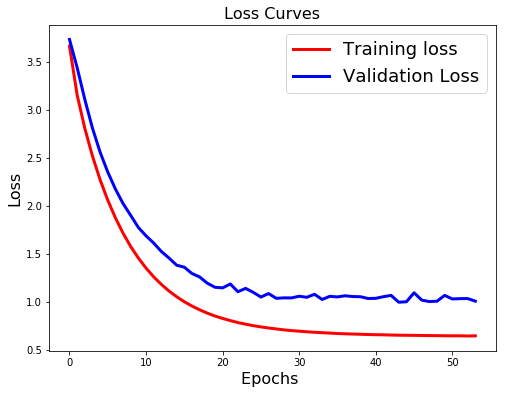

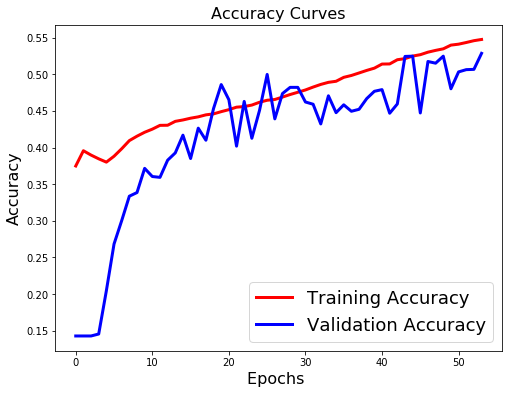

In [0]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

# Performance: GSPC

In [0]:
VarName = 'GSPC'

test_filename = "LW5_IW30/" + ts_direct + "/" + Test + "_" + VarName + "_1B_ReturnTrue_LWS5_IWS30_Trf['RP', 'GASF', 'MTF'].npz"

data_test = np.load('/content/drive/My Drive/Colab Notebooks/CNN/' + test_filename)

In [0]:
images_test = data_test['images']
image_labels_test = data_test['image_labels']
test_prices = data_test['price_at_image']

In [0]:
t0 = time.time()
image_labels_pred = model1.predict(images_test)
image_labels_pred = np.where(image_labels_pred > 0.5, 1, 0)
t1 = time.time()

total_prediction_time = t1-t0

In [0]:
y_true = np.argmax(image_labels_test,1) 
y_pred = np.argmax(image_labels_pred,1)

## Confusion Matrix

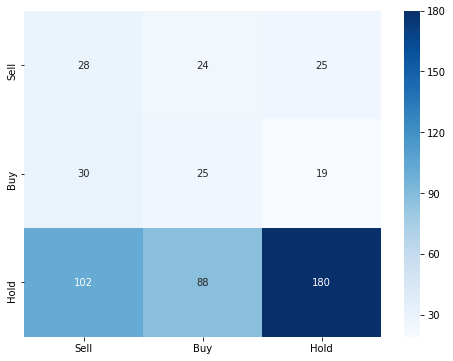

In [0]:
cm =  pd.DataFrame(confusion_matrix(y_true, y_pred), 
                                 index = label_names_array, 
                                 columns = label_names_array)

plt.figure(figsize=[8,6])
sn.heatmap(cm, annot=True,cmap='Blues', fmt='g')

## Classification Metrics

In [0]:
target_names = label_names_array
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Sell       0.17      0.36      0.24        77
         Buy       0.18      0.34      0.24        74
        Hold       0.80      0.49      0.61       370

    accuracy                           0.45       521
   macro avg       0.39      0.40      0.36       521
weighted avg       0.62      0.45      0.50       521



## Time spent

In [0]:
total_training_time = sum(time_callback.times)
print("Time spent on entire model training: {:4f} seconds".format(total_training_time))

Time spent on entire model training: 1918.390671 seconds


## Financial Evaluation, Save predicton data in given format

In [0]:
#custom library
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/CNN/evaluation')
import financial_evaluation

In [0]:
# Create Signals from numbers here 
Signals = y_pred

prediction = pd.DataFrame(test_prices, columns = [VarName])
prediction['Signals'] = Signals
prediction['Signals'].loc[prediction['Signals'] == 0] = "Sell"
prediction['Signals'].loc[prediction['Signals'] == 1] = "Buy"
prediction['Signals'].loc[prediction['Signals'] == 2] = "Hold"

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
#save results
prediction.to_csv('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/PredForFinEval.csv")

In [0]:
fin_res = financial_evaluation.financial_evaluation(VarName, test_prices, prediction['Signals'], safety = True)
print(VarName + ": Annualized return is {}, cumulative return is {} and number of trades are {}.".format(fin_res['annualized_return'], fin_res['cumulative_return'], fin_res['all_trades']))

GSPC: Annualized return is [0.15414776], cumulative return is [0.33279175] and number of trades are 74.


## Save Model

In [0]:
model1.save('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/model.h5")

## Save true and pred

In [0]:
TruePred = pd.DataFrame(y_true, columns = [VarName])
TruePred['Prediction'] = y_pred
TruePred.to_csv('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/True&Pred.csv")

## Save Classification Metrics &  Save Times


In [0]:
Acc = np.float(accuracy_score(y_true=y_true, y_pred=y_pred))
#F1 = np.float(f1_score(y_true = y_true, y_pred = y_pred, average = 'macro'))
Prec = np.float(precision_score(y_true=y_true, y_pred=y_pred, average = 'macro'))
Recall = np.float(recall_score(y_true=y_true, y_pred=y_pred, average = 'macro'))

F1 = 2 * (Prec * Recall) / (Prec + Recall)

print(Acc, F1, Prec, Recall)

0.4472168905950096 0.3914509413283395 0.3870177267987487 0.39598689598689596


In [0]:
np.savez('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/Time&ClassificationEval.npz",
         accuracy = Acc,
         MacF1 = F1,
         MacPrecision = Prec,
         MacRecall = Recall,
         TrainTime = np.float(total_training_time),
         PredTime = np.float(total_prediction_time)
        )

# Performance: AAPL

In [0]:
VarName = 'AAPL'

test_filename = "LW5_IW30/" + ts_direct + "/" + Test + "_" + VarName + "_1B_ReturnTrue_LWS5_IWS30_Trf['RP', 'GASF', 'MTF'].npz"

data_test = np.load('/content/drive/My Drive/Colab Notebooks/CNN/' + test_filename)

In [0]:
images_test = data_test['images']
image_labels_test = data_test['image_labels']
test_prices = data_test['price_at_image']

In [0]:
t0 = time.time()
image_labels_pred = model1.predict(images_test)
image_labels_pred = np.where(image_labels_pred > 0.5, 1, 0)
t1 = time.time()

total_prediction_time = t1-t0

In [0]:
y_true = np.argmax(image_labels_test,1) 
y_pred = np.argmax(image_labels_pred,1)

## Confusion Matrix

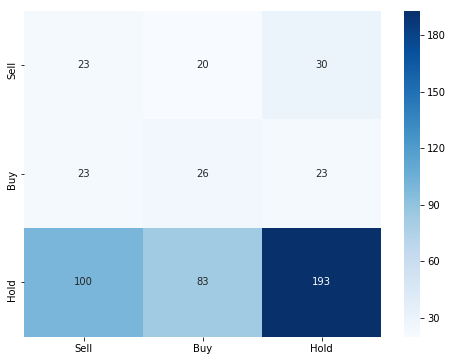

In [0]:
cm =  pd.DataFrame(confusion_matrix(y_true, y_pred), 
                                 index = label_names_array, 
                                 columns = label_names_array)

plt.figure(figsize=[8,6])
sn.heatmap(cm, annot=True,cmap='Blues', fmt='g')

## Classification Metrics

In [0]:
target_names = label_names_array
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Sell       0.16      0.32      0.21        73
         Buy       0.20      0.36      0.26        72
        Hold       0.78      0.51      0.62       376

    accuracy                           0.46       521
   macro avg       0.38      0.40      0.36       521
weighted avg       0.62      0.46      0.51       521



## Financial Evaluation, Save predicton data in given format

In [0]:
#custom library
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/CNN/evaluation')
import financial_evaluation

In [0]:
# Create Signals from numbers here 
Signals = y_pred

prediction = pd.DataFrame(test_prices, columns = [VarName])
prediction['Signals'] = Signals
prediction['Signals'].loc[prediction['Signals'] == 0] = "Sell"
prediction['Signals'].loc[prediction['Signals'] == 1] = "Buy"
prediction['Signals'].loc[prediction['Signals'] == 2] = "Hold"

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
#save results
prediction.to_csv('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/PredForFinEval.csv")

In [0]:
fin_res = financial_evaluation.financial_evaluation(VarName, test_prices, prediction['Signals'], safety = True)
print(VarName + ": Annualized return is {}, cumulative return is {} and number of trades are {}.".format(fin_res['annualized_return'], fin_res['cumulative_return'], fin_res['all_trades']))

AAPL: Annualized return is [0.03998955], cumulative return is [0.08174138] and number of trades are 72.


## Save Model

In [0]:
model1.save('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/model.h5")

## Save true and pred

In [0]:
TruePred = pd.DataFrame(y_true, columns = [VarName])
TruePred['Prediction'] = y_pred
TruePred.to_csv('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/True&Pred.csv")

## Save Classification Metrics &  Save Times


In [0]:
Acc = np.float(accuracy_score(y_true=y_true, y_pred=y_pred))
#F1 = np.float(f1_score(y_true = y_true, y_pred = y_pred, average = 'macro'))
Prec = np.float(precision_score(y_true=y_true, y_pred=y_pred, average = 'macro'))
Recall = np.float(recall_score(y_true=y_true, y_pred=y_pred, average = 'macro'))

F1 = 2 * (Prec * Recall) / (Prec + Recall)

print(Acc, F1, Prec, Recall)

0.46449136276391556 0.3887023854317366 0.38121249323356565 0.3964924922007405


In [0]:
np.savez('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/Time&ClassificationEval.npz",
         accuracy = Acc,
         MacF1 = F1,
         MacPrecision = Prec,
         MacRecall = Recall,
         TrainTime = np.float(total_training_time),
         PredTime = np.float(total_prediction_time)
        )

# Performance: IXIC

In [0]:
VarName = 'IXIC'

test_filename = "LW5_IW30/" + ts_direct + "/" + Test + "_" + VarName + "_1B_ReturnTrue_LWS5_IWS30_Trf['RP', 'GASF', 'MTF'].npz"

data_test = np.load('/content/drive/My Drive/Colab Notebooks/CNN/' + test_filename)

In [0]:
images_test = data_test['images']
image_labels_test = data_test['image_labels']
test_prices = data_test['price_at_image']

In [0]:
t0 = time.time()
image_labels_pred = model1.predict(images_test)
image_labels_pred = np.where(image_labels_pred > 0.5, 1, 0)
t1 = time.time()

total_prediction_time = t1-t0

In [0]:
y_true = np.argmax(image_labels_test,1) 
y_pred = np.argmax(image_labels_pred,1)

## Confusion Matrix

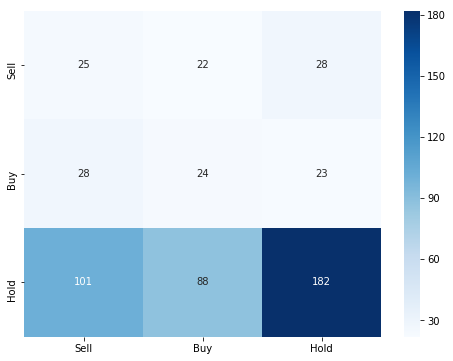

In [0]:
cm =  pd.DataFrame(confusion_matrix(y_true, y_pred), 
                                 index = label_names_array, 
                                 columns = label_names_array)

plt.figure(figsize=[8,6])
sn.heatmap(cm, annot=True,cmap='Blues', fmt='g')

## Classification Metrics

In [0]:
target_names = label_names_array
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Sell       0.16      0.33      0.22        75
         Buy       0.18      0.32      0.23        75
        Hold       0.78      0.49      0.60       371

    accuracy                           0.44       521
   macro avg       0.37      0.38      0.35       521
weighted avg       0.61      0.44      0.49       521



## Financial Evaluation, Save predicton data in given format

In [0]:
#custom library
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/CNN/evaluation')
import financial_evaluation

In [0]:
# Create Signals from numbers here 
Signals = y_pred

prediction = pd.DataFrame(test_prices, columns = [VarName])
prediction['Signals'] = Signals
prediction['Signals'].loc[prediction['Signals'] == 0] = "Sell"
prediction['Signals'].loc[prediction['Signals'] == 1] = "Buy"
prediction['Signals'].loc[prediction['Signals'] == 2] = "Hold"

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
#save results
prediction.to_csv('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/PredForFinEval.csv")

In [0]:
fin_res = financial_evaluation.financial_evaluation(VarName, test_prices, prediction['Signals'], safety = True)
print(VarName + ": Annualized return is {}, cumulative return is {} and number of trades are {}.".format(fin_res['annualized_return'], fin_res['cumulative_return'], fin_res['all_trades']))

IXIC: Annualized return is [0.06708745], cumulative return is [0.13896003] and number of trades are 68.


## Save Model

In [0]:
model1.save('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/model.h5")

## Save true and pred

In [0]:
TruePred = pd.DataFrame(y_true, columns = [VarName])
TruePred['Prediction'] = y_pred
TruePred.to_csv('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/True&Pred.csv")

## Save Classification Metrics &  Save Times


In [0]:
Acc = np.float(accuracy_score(y_true=y_true, y_pred=y_pred))
#F1 = np.float(f1_score(y_true = y_true, y_pred = y_pred, average = 'macro'))
Prec = np.float(precision_score(y_true=y_true, y_pred=y_pred, average = 'macro'))
Recall = np.float(recall_score(y_true=y_true, y_pred=y_pred, average = 'macro'))

F1 = 2 * (Prec * Recall) / (Prec + Recall)

print(Acc, F1, Prec, Recall)

0.44337811900191937 0.3777094061708632 0.37418600659264295 0.3812997903563941


In [0]:
np.savez('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/Time&ClassificationEval.npz",
         accuracy = Acc,
         MacF1 = F1,
         MacPrecision = Prec,
         MacRecall = Recall,
         TrainTime = np.float(total_training_time),
         PredTime = np.float(total_prediction_time)
        )

# Performance: N225

In [0]:
VarName = 'N225'

test_filename = "LW5_IW30/" + ts_direct + "/" + Test + "_" + VarName + "_1B_ReturnTrue_LWS5_IWS30_Trf['RP', 'GASF', 'MTF'].npz"

data_test = np.load('/content/drive/My Drive/Colab Notebooks/CNN/' + test_filename)

In [0]:
images_test = data_test['images']
image_labels_test = data_test['image_labels']
test_prices = data_test['price_at_image']

In [0]:
t0 = time.time()
image_labels_pred = model1.predict(images_test)
image_labels_pred = np.where(image_labels_pred > 0.5, 1, 0)
t1 = time.time()

total_prediction_time = t1-t0

In [0]:
y_true = np.argmax(image_labels_test,1) 
y_pred = np.argmax(image_labels_pred,1)

## Confusion Matrix

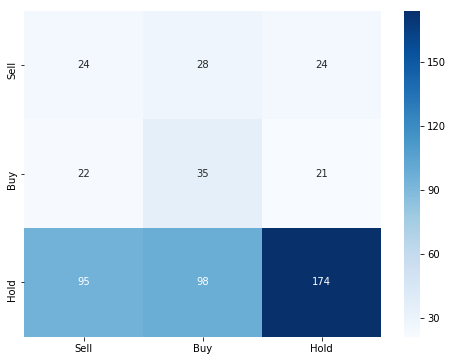

In [0]:
cm =  pd.DataFrame(confusion_matrix(y_true, y_pred), 
                                 index = label_names_array, 
                                 columns = label_names_array)

plt.figure(figsize=[8,6])
sn.heatmap(cm, annot=True,cmap='Blues', fmt='g')

## Classification Metrics

In [0]:
target_names = label_names_array
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Sell       0.17      0.32      0.22        76
         Buy       0.22      0.45      0.29        78
        Hold       0.79      0.47      0.59       367

    accuracy                           0.45       521
   macro avg       0.39      0.41      0.37       521
weighted avg       0.62      0.45      0.49       521



## Financial Evaluation, Save predicton data in given format

In [0]:
#custom library
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/CNN/evaluation')
import financial_evaluation

In [0]:
# Create Signals from numbers here 
Signals = y_pred

prediction = pd.DataFrame(test_prices, columns = [VarName])
prediction['Signals'] = Signals
prediction['Signals'].loc[prediction['Signals'] == 0] = "Sell"
prediction['Signals'].loc[prediction['Signals'] == 1] = "Buy"
prediction['Signals'].loc[prediction['Signals'] == 2] = "Hold"

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
#save results
prediction.to_csv('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/PredForFinEval.csv")

In [0]:
fin_res = financial_evaluation.financial_evaluation(VarName, test_prices, prediction['Signals'], safety = True)
print(VarName + ": Annualized return is {}, cumulative return is {} and number of trades are {}.".format(fin_res['annualized_return'], fin_res['cumulative_return'], fin_res['all_trades']))

N225: Annualized return is [0.00754924], cumulative return is [0.01518484] and number of trades are 76.


## Save Model

In [0]:
model1.save('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/model.h5")

## Save true and pred

In [0]:
TruePred = pd.DataFrame(y_true, columns = [VarName])
TruePred['Prediction'] = y_pred
TruePred.to_csv('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/True&Pred.csv")

## Save Classification Metrics &  Save Times


In [0]:
Acc = np.float(accuracy_score(y_true=y_true, y_pred=y_pred))
#F1 = np.float(f1_score(y_true = y_true, y_pred = y_pred, average = 'macro'))
Prec = np.float(precision_score(y_true=y_true, y_pred=y_pred, average = 'macro'))
Recall = np.float(recall_score(y_true=y_true, y_pred=y_pred, average = 'macro'))

F1 = 2 * (Prec * Recall) / (Prec + Recall)

print(Acc, F1, Prec, Recall)

0.4472168905950096 0.4032379843075027 0.3940415394168261 0.41287395460635096


In [0]:
np.savez('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/Time&ClassificationEval.npz",
         accuracy = Acc,
         MacF1 = F1,
         MacPrecision = Prec,
         MacRecall = Recall,
         TrainTime = np.float(total_training_time),
         PredTime = np.float(total_prediction_time)
        )

# Performance: SPY

In [0]:
VarName = 'SPY'

test_filename = "LW5_IW30/" + ts_direct + "/" + Test + "_" + VarName + "_1B_ReturnTrue_LWS5_IWS30_Trf['RP', 'GASF', 'MTF'].npz"

data_test = np.load('/content/drive/My Drive/Colab Notebooks/CNN/' + test_filename)

In [0]:
images_test = data_test['images']
image_labels_test = data_test['image_labels']
test_prices = data_test['price_at_image']

In [0]:
t0 = time.time()
image_labels_pred = model1.predict(images_test)
image_labels_pred = np.where(image_labels_pred > 0.5, 1, 0)
t1 = time.time()

total_prediction_time = t1-t0

In [0]:
y_true = np.argmax(image_labels_test,1) 
y_pred = np.argmax(image_labels_pred,1)

## Confusion Matrix

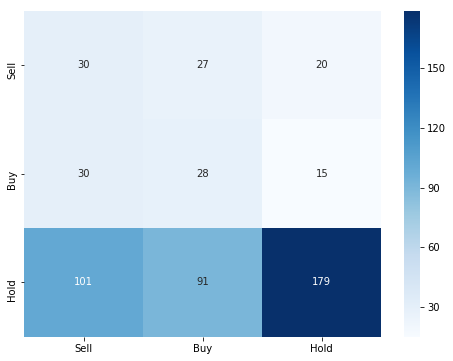

In [0]:
cm =  pd.DataFrame(confusion_matrix(y_true, y_pred), 
                                 index = label_names_array, 
                                 columns = label_names_array)

plt.figure(figsize=[8,6])
sn.heatmap(cm, annot=True,cmap='Blues', fmt='g')

## Classification Metrics

In [0]:
target_names = label_names_array
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Sell       0.19      0.39      0.25        77
         Buy       0.19      0.38      0.26        73
        Hold       0.84      0.48      0.61       371

    accuracy                           0.45       521
   macro avg       0.40      0.42      0.37       521
weighted avg       0.65      0.45      0.51       521



## Time spent

In [0]:
total_training_time = sum(time_callback.times)
print("Time spent on entire model training: {:4f} seconds".format(total_training_time))

Time spent on entire model training: 1918.390671 seconds


## Financial Evaluation, Save predicton data in given format

In [0]:
#custom library
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/CNN/evaluation')
import financial_evaluation

In [0]:
# Create Signals from numbers here 
Signals = y_pred

prediction = pd.DataFrame(test_prices, columns = [VarName])
prediction['Signals'] = Signals
prediction['Signals'].loc[prediction['Signals'] == 0] = "Sell"
prediction['Signals'].loc[prediction['Signals'] == 1] = "Buy"
prediction['Signals'].loc[prediction['Signals'] == 2] = "Hold"

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
#save results
prediction.to_csv('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/PredForFinEval.csv")

In [0]:
fin_res = financial_evaluation.financial_evaluation(VarName, test_prices, prediction['Signals'], safety = True)
print(VarName + ": Annualized return is {}, cumulative return is {} and number of trades are {}.".format(fin_res['annualized_return'], fin_res['cumulative_return'], fin_res['all_trades']))

SPY: Annualized return is [0.29263476], cumulative return is [0.67255504] and number of trades are 86.


## Save Model

In [0]:
model1.save('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/model.h5")

## Save true and pred

In [0]:
TruePred = pd.DataFrame(y_true, columns = [VarName])
TruePred['Prediction'] = y_pred
TruePred.to_csv('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/True&Pred.csv")

## Save Classification Metrics &  Save Times


In [0]:
Acc = np.float(accuracy_score(y_true=y_true, y_pred=y_pred))
#F1 = np.float(f1_score(y_true = y_true, y_pred = y_pred, average = 'macro'))
Prec = np.float(precision_score(y_true=y_true, y_pred=y_pred, average = 'macro'))
Recall = np.float(recall_score(y_true=y_true, y_pred=y_pred, average = 'macro'))

F1 = 2 * (Prec * Recall) / (Prec + Recall)

print(Acc, F1, Prec, Recall)

0.45489443378119004 0.4115888739335778 0.4048549412584525 0.41855060593752763


In [0]:
np.savez('drive/My Drive/Colab Notebooks/CNN/Results/' + Test + "/" + Version[1:-1] + "/" + VarName + "/Time&ClassificationEval.npz",
         accuracy = Acc,
         MacF1 = F1,
         MacPrecision = Prec,
         MacRecall = Recall,
         TrainTime = np.float(total_training_time),
         PredTime = np.float(total_prediction_time)
        )